# SHRED-ROM Tutorial on Double Gyre Flow

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1MSmKFJPf0B81iAN2hjU-3IvFgimUBIc9)

The double gyre flow is a time-dependent model for two counter-rotating vortices (gyres) in a rectangular domain. When time is introduced via a periodic perturbation, the central dividing line between the two gyres oscillates left and right, creating a time-varying velocity field that can lead to chaotic particle trajectories. The velocity field $\mathbf{v} = [u, v]^T$ in the domain $[0, L_x] \times [0, L_y]$ and in the time interval $[0, T]$ is given by


$$
\begin{align}
u(x, y, t) &= -\pi I \sin\left( \pi f(x, t) \right) \cos\left( \pi y \right)
\\
v(x, y, t) &= \pi I \cos\left( \pi f(x, t) \right) \sin\left( \pi y \right) \frac{\partial f}{\partial x}
\end{align}
$$

\
where $I$ is the intensity parameter, $f(x, t) = \epsilon \sin(\omega t) x^2 + (1 - 2\epsilon \sin(\omega t)) x $, $\epsilon$ and $\omega$ are the perturbation amplitude and the frequency of the oscillation, respectively.

In [22]:
%load_ext autoreload
%autoreload 2
# PYSHRED
from pyshred import DataManager, SHRED, SHREDEngine, LSTM_Forecaster

# IMPORT LIBRARIES
import torch
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# DEFINE THE SYSTEM SOLVER

def double_gyre_flow(amplitude, frequency, x, y, t):
    '''
    Solve the double gyre flow problem

    Inputs
        amplitude                   (`float`)
        frequency                   (`float`)
        horizontal discretization   (`np.array[float]`, shape: (ny,))
        vertical discretization     (`np.array[float]`, shape: (nx,))
        time vector                 (`np.array[float]`, shape: (ntimes,))

    Output
        horizontal velocity matrix  (`np.array[float]`, shape: (ntimes, nx * ny)
        vertical velocity matrix    (`np.array[float]`, shape: (ntimes, nx * ny)
    '''

    xgrid, ygrid = np.meshgrid(x, y)         # spatial grid

    u = np.zeros((len(t), len(x), len(y)))   # horizontal velocity
    v = np.zeros((len(t), len(x), len(y)))   # vertical velocity

    intensity = 0.1   # intensity parameter

    f = lambda x,t: amplitude * np.sin(frequency * t) * x**2 + x - 2 * amplitude * np.sin(frequency * t) * x

    # compute solution
    for i in range(len(t)):
      u[i] = (-np.pi * intensity * np.sin(np.pi * f(xgrid, t[i])) * np.cos(np.pi * ygrid)).T
      v[i] = (np.pi * intensity * np.cos(np.pi * f(xgrid, t[i])) * np.sin(np.pi * ygrid) * (2 * amplitude * np.sin(frequency * t[i]) * xgrid + 1.0 - 2 * amplitude * np.sin(frequency * t[i]))).T

    return u, v

In [24]:
# SOLVE THE SYSTEM FOR A FIXED TRANSPORT TERM

amplitude = 0.25    # amplitude
frequency = 5.0     # frequency

# spatial discretization
nx = 50
ny = 25
Lx = 2.0
Ly = 1.0
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
nstate = len(x) * len(y)

# temporal discretization
dt = 0.1
T = 10.0
t = np.arange(0, T + dt, dt)
ntimes = len(t)

u, v = double_gyre_flow(amplitude, frequency, x, y, t)

In [25]:
# SOLUTION VISUALIZATION

from ipywidgets import interact, FloatSlider
import matplotlib.patches as patches

def vorticity(u, v):
    dx = Lx / nx
    dy = Ly / ny
    du_dy = np.gradient(u, dy, axis = 1)
    dv_dx = np.gradient(v, dx, axis = 0)
    return dv_dx - du_dy

def plot_solution(time):

    which_time = (np.abs(t - time)).argmin()
    offset = 0.1

    plt.figure(figsize = (10,5))
    plt.contourf(x, y, vorticity(u[which_time], v[which_time]).T, cmap = 'seismic', levels = 100)
    plt.streamplot(x, y, u[which_time].T, v[which_time].T, color='black', linewidth = 1, density = 1)
    plt.axis('off')
    plt.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    plt.title(f'Solution at time t = {round(time, 3)}')
    plt.grid(True)
    plt.gca().add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))


interact(plot_solution, time = FloatSlider(value = t[0], min = t[0], max = t[-1], step = (t[1]-t[0]), description='time', layout={'width': '400px', 'height': '50px'}));

interactive(children=(FloatSlider(value=0.0, description='time', layout=Layout(height='50px', width='400px'), …

In [26]:
# DATA GENERATION

amplitude_range = np.array([0.0, 0.5])
frequency_range = np.array([0.5, 2*np.pi])

# spatial discretization
nx = 50
ny = 25
Lx = 2.0
Ly = 1.0
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
nstate = len(x) * len(y)

# temporal discretization
dt = 0.1
T = 10.0
t = np.arange(0, T + dt, dt)
ntimes = len(t)

# training data generation
ntrajectories = 100
U = np.zeros((ntrajectories, ntimes, nx, ny))
V = np.zeros((ntrajectories, ntimes, nx, ny))

for i in range(ntrajectories):
  amplitude = (amplitude_range[1] - amplitude_range[0]) * np.random.rand() + amplitude_range[0]
  frequency = (frequency_range[1] - frequency_range[0]) * np.random.rand() + frequency_range[0]
  U[i], V[i] = double_gyre_flow(amplitude, frequency, x, y, t)

In [27]:
# DATA VISUALIZATION

from ipywidgets import interact, IntSlider

def plot_data(which_trajectory, which_time):

    offset = 0.1

    plt.figure(figsize = (10,5))
    plt.contourf(x, y, vorticity(U[which_trajectory, which_time], V[which_trajectory, which_time]).T, cmap = 'seismic', levels = 100)
    plt.streamplot(x, y, U[which_trajectory, which_time].T, V[which_trajectory, which_time].T, color='black', linewidth = 1, density = 1)
    plt.axis('off')
    plt.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    plt.title(f'Trajectory {which_trajectory} at time t = {round(t[which_time], 3)}')
    plt.grid(True)
    plt.gca().add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))

interact(plot_data, which_trajectory = IntSlider(min = 0, max = ntrajectories - 1, step = 1, description='Trajectory'), which_time = IntSlider(min = 0, max = ntimes - 1, step = 1, description='Time step'));

interactive(children=(IntSlider(value=0, description='Trajectory', max=99), IntSlider(value=0, description='Ti…

## **SHallow REcurrent Decoder networks-based Reduced Order Modeling (SHRED-ROM)**

Let us assume to have three sensors in the domain measuring the horizontal velocity $u(x_s,y_s,t;\epsilon, \omega)$ over time. *SHRED-ROM* aims to reconstruct the temporal evolution of the entire velocity $\mathbf{v}(x,y,t;\epsilon, \omega) = [u(x,y,t;\epsilon, \omega), v(x,y,t;\epsilon, \omega)]^T$ starting from the limited sensor measurements available. In general, *SHRED-ROM* combines a recurrent neural network (LSTM), which encodes the temporal history of sensor values in multiple parametric regimes, and a shallow decoder, which projects the LSTM prediction to the (possibly high-dimensional) state dimension. Note that, to enhance computational efficiency and memory usage, dimensionality reduction strategies (such as, e.g., POD) may be considered to compress the training snapshots.


In [28]:
from pyshred import ParametricDataManager, SHRED, ParametricSHREDEngine
# Initialize ParametricSHREDDataManager
manager = ParametricDataManager(
    lags = 25,
    train_size = 0.8,
    val_size = 0.1,
    test_size = 0.1,
    )

In [29]:
manager.add_data(
    data=U,         # 3D array (time, lat, lon); time must be on axis 0
    id="U",          # Unique identifier for the dataset
    random=3,          # Randomly select 3 sensor locations
    compress=4     # Keep original spatial resolution (no compression)
)

In [30]:
manager.add_data(
    data=V,         # 3D array (time, lat, lon); time must be on axis 0
    id="V",          # Unique identifier for the dataset
    compress=4     # Keep original spatial resolution (no compression)
)

In [31]:
manager.sensor_summary_df

,data id,sensor_number,type,loc/traj
0,U,0,stationary (random),"(1, 19)"
1,U,1,stationary (random),"(14, 17)"
2,U,2,stationary (random),"(3, 15)"


In [32]:
manager.sensor_measurements_df

,U-0,U-1,U-2
0,0.031872,0.186453,0.045116
1,0.027695,0.190989,0.039657
2,0.024161,0.190413,0.034973
3,0.021824,0.187821,0.031846
4,0.021051,0.186582,0.030808
...,...,...,...
10095,0.019757,0.184086,0.029064
10096,0.020774,0.186092,0.030435
10097,0.021880,0.187904,0.031922
10098,0.023065,0.189416,0.033510


In [33]:
train_dataset, val_dataset, test_dataset= manager.prepare()

In [34]:
shred = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster=None
)

In [35]:
val_errors = shred.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=100,
    patience=100,
    verbose=True,
)

print('val_errors:', val_errors)

Fitting SHRED...
Epoch 1: Average training loss = 0.046301
Validation MSE (epoch 1): 0.032853
Epoch 2: Average training loss = 0.029679
Validation MSE (epoch 2): 0.019704
Epoch 3: Average training loss = 0.018568
Validation MSE (epoch 3): 0.013509
Epoch 4: Average training loss = 0.014708
Validation MSE (epoch 4): 0.011551
Epoch 5: Average training loss = 0.013780
Validation MSE (epoch 5): 0.010186
Epoch 6: Average training loss = 0.012296
Validation MSE (epoch 6): 0.009106
Epoch 7: Average training loss = 0.011431
Validation MSE (epoch 7): 0.009143
Epoch 8: Average training loss = 0.010653
Validation MSE (epoch 8): 0.008373
Epoch 9: Average training loss = 0.010423
Validation MSE (epoch 9): 0.008690
Epoch 10: Average training loss = 0.010159
Validation MSE (epoch 10): 0.008197
Epoch 11: Average training loss = 0.009842
Validation MSE (epoch 11): 0.008308
Epoch 12: Average training loss = 0.009597
Validation MSE (epoch 12): 0.008245
Epoch 13: Average training loss = 0.009303
Validation

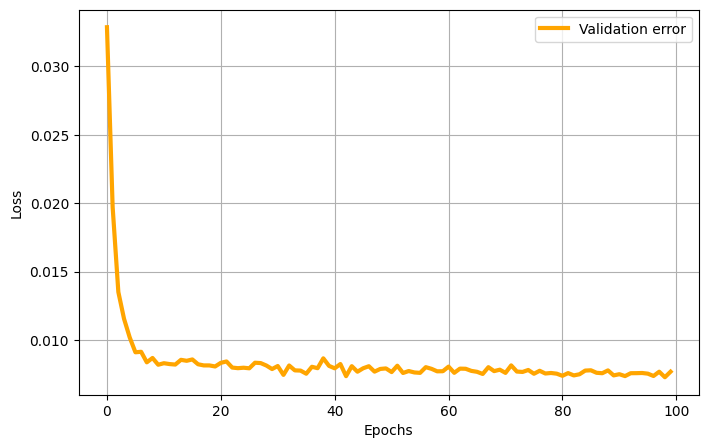

In [36]:
# TRAINING HISTORY VISUALIZATION

plt.figure(figsize = (8,5))
# plt.plot(train_errors, 'k', linewidth = 3, label = 'Training error')
plt.plot(val_errors, 'orange', linewidth = 3, label = 'Validation error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [37]:
train_mse = shred.evaluate(dataset=train_dataset)
val_mse = shred.evaluate(dataset=val_dataset)
test_mse = shred.evaluate(dataset=test_dataset)
print(f"Train MSE: {train_mse:.3f}")
print(f"Val   MSE: {val_mse:.3f}")
print(f"Test  MSE: {test_mse:.3f}")

Train MSE: 0.008
Val   MSE: 0.008
Test  MSE: 0.008


In [38]:
engine = ParametricSHREDEngine(manager, shred)

In [39]:
# obtain latent space of test sensor measurements
test_latent_from_sensors = engine.sensor_to_latent(manager.test_sensor_measurements)

In [40]:
# decode latent space generated from sensor measurements (generated using engine.sensor_to_latent())
test_reconstruction = engine.decode(test_latent_from_sensors)

In [41]:
Utest_hat = test_reconstruction['U']
Vtest_hat = test_reconstruction['V']
Utest = U[manager.test_indices]
Vtest = V[manager.test_indices]

In [42]:
# SHRED RECONSTRUCTION VISUALIZATION

from ipywidgets import interact, IntSlider

Utest_hat = Utest_hat.reshape(-1, ntimes, nx, ny)
Utest = Utest.reshape(-1, ntimes, nx, ny)

Vtest_hat = Vtest_hat.reshape(-1, ntimes, nx, ny)
Vtest = Vtest.reshape(-1, ntimes, nx, ny)

def plot_shred_reconstruction(which_test_trajectory, which_time):

    offset = 0.1

    plt.figure(figsize = (20,5))
    plt.subplot(1, 2, 1)
    plt.contourf(x, y, vorticity(Utest[which_test_trajectory, which_time],  Vtest[which_test_trajectory, which_time]).T, cmap = 'seismic', levels = 100)
    plt.streamplot(x, y, Utest[which_test_trajectory, which_time].T, Vtest[which_test_trajectory, which_time].T, color='black', linewidth = 1, density = 1)
    plt.axis('off')
    plt.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    plt.title(f'Test case {which_test_trajectory} at time t = {round(t[which_time], 3)}')
    plt.grid(True)
    plt.gca().add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))
    # for k in range(3):
    #   plt.plot(sensors_coordinates[0, k], sensors_coordinates[1, k], 'o', mfc = 'magenta', mec = 'black', ms = 8, mew = 1.5)

    plt.subplot(1, 2, 2)
    plt.contourf(x, y, vorticity(Utest_hat[which_test_trajectory, which_time],  Vtest_hat[which_test_trajectory, which_time]).T, cmap = 'seismic', levels = 100)
    plt.streamplot(x, y, Utest_hat[which_test_trajectory, which_time].T, Vtest_hat[which_test_trajectory, which_time].T, color='black', linewidth = 1, density = 1)
    plt.axis('off')
    plt.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    plt.title(f'SHRED reconstruction at time t = {round(t[which_time], 3)}')
    plt.grid(True)
    plt.gca().add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))
    # for k in range(nsensors):
    #   plt.plot(sensors_coordinates[0, k], sensors_coordinates[1, k], 'o', mfc = 'magenta', mec = 'black', ms = 8, mew = 1.5)

interact(plot_shred_reconstruction, which_test_trajectory = IntSlider(value = 0, min = 0, max = len(Utest) - 1, description='Test case'), which_time = IntSlider(min = 0, max = ntimes - 1, step = 1, description='Time step'));

interactive(children=(IntSlider(value=0, description='Test case', max=9), IntSlider(value=0, description='Time…